<a href="https://www.kaggle.com/swanandkulkarni1729/petals-to-the-metal-with-custom?scriptVersionId=85460519" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import numpy as np


2022-01-17 15:03:14.149481: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()#Google cloud storage bucket path

In [5]:
IMAGE_SIZE = [192, 192] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 20
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()


2022-01-17 15:03:19.971510: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Couldn't resolve host 'metadata'".
2022-01-17 15:03:20.705422: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-17 15:03:20.708774: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-17 15:03:20.758809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 15:03:20.759901: I ten

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

with strategy.scope():
    model = keras.Sequential([
        layers.InputLayer(input_shape = [192, 192, 3]),
        #augmentation
        preprocessing.RandomFlip('horizontal'),
        preprocessing.RandomFlip('vertical'),
        preprocessing.RandomWidth(factor = 0.15),
        preprocessing.RandomRotation(factor = 0.20),
        preprocessing.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        #block1
        layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu',  padding ='SAME'),
        layers.MaxPool2D(),
        #block2
        layers.BatchNormalization(renorm = True),
        layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'SAME'),
        layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'SAME'),
        layers.MaxPool2D(),
        #block3
        layers.BatchNormalization(renorm = True),
        layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'SAME'),
        layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'SAME'),
        layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'SAME'),
        layers.MaxPool2D(),
        #block4
        layers.BatchNormalization(renorm = True),
        layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'SAME'),
        layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'SAME'),
        layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'SAME'),
        layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'SAME'),
        layers.MaxPool2D(),
        #headblock
        layers.BatchNormalization(renorm = True),
        layers.GlobalAveragePooling2D(),
        layers.Dense(104, activation = 'softmax'),
    ])
    
model.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy']
)

history = model.fit( training_dataset,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_dataset
)

Epoch 1/20


2022-01-17 15:03:26.882546: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-17 15:03:26.901399: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2022-01-17 15:03:27.449914: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-17 15:03:28.406865: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-01-17 15:03:36.695833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


797/797 [==============================] - 141s 154ms/step - loss: 5.4955 - sparse_categorical_accuracy: 0.0601 - val_loss: 3.7836 - val_sparse_categorical_accuracy: 0.1072
Epoch 2/20
797/797 [==============================] - 79s 100ms/step - loss: 4.6238 - sparse_categorical_accuracy: 0.1011 - val_loss: 3.5761 - val_sparse_categorical_accuracy: 0.1363
Epoch 3/20
797/797 [==============================] - 77s 97ms/step - loss: 3.5654 - sparse_categorical_accuracy: 0.1372 - val_loss: 3.3982 - val_sparse_categorical_accuracy: 0.1536
Epoch 4/20
797/797 [==============================] - 79s 100ms/step - loss: 3.4804 - sparse_categorical_accuracy: 0.1463 - val_loss: 4.1442 - val_sparse_categorical_accuracy: 0.0811
Epoch 5/20
797/797 [==============================] - 78s 98ms/step - loss: 3.6728 - sparse_categorical_accuracy: 0.1228 - val_loss: 3.3739 - val_sparse_categorical_accuracy: 0.1765
Epoch 6/20
797/797 [==============================] - 80s 100ms/step - loss: 3.3282 - sparse_cate

<AxesSubplot:>

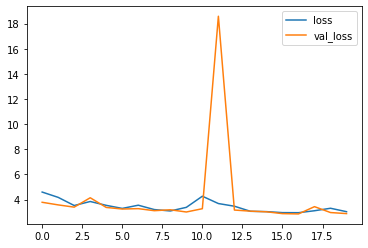

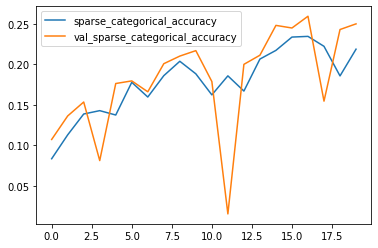

In [8]:
import pandas as pd
df = pd.DataFrame(history.history)
df.loc[:, ['loss', 'val_loss']].plot()
df.loc[:,['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()